## Genome Manual Transformation Demo
Show a program can successfully evolve from BFS to DFS using manual transformations
1. Directly on XML elements
2. Using Genome representation

In [1]:
import os, json

from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.orm import sessionmaker

from models import Prototypes, Ingredient, Base
import matplotlib.pyplot as plt

dfs_hash = 'ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0'
bfs_hash = '80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204'

# Import settings
setting_file = os.path.abspath(os.path.join('..', 'settings.json'))

with open(setting_file, 'r') as f:
    settings = json.load(f)

# connect to database
# create engine, connection, and session
engine = create_engine(settings['sqlalchemy_database_uri'])
conn = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()

# create tables
Base.metadata.create_all(engine)

prototype_dfs = session.query(Prototypes).filter(Prototypes.hash == dfs_hash).first()
prototype_bfs = session.query(Prototypes).filter(Prototypes.hash == bfs_hash).first()

In [2]:
# write everything to files
dfs_code_filepath = os.path.join('tmp', 'dfs.c')
with open(dfs_code_filepath, 'w') as f:
    f.write(prototype_dfs.code)

bfs_code_filepath = os.path.join('tmp', 'bfs.c')
with open(bfs_code_filepath, 'w') as f:
    f.write(prototype_bfs.code)

dfs_xml_filepath = os.path.join('tmp', 'dfs.xml')
with open(dfs_xml_filepath, 'w') as f:
    f.write(prototype_dfs.xml)

bfs_xml_filepath = os.path.join('tmp', 'bfs.xml')
with open(bfs_xml_filepath, 'w') as f:
    f.write(prototype_bfs.xml)

In [3]:
import xml.etree.ElementTree as ET

# get tree for each genome
dfs_tree = ET.parse(dfs_xml_filepath)
bfs_tree = ET.parse(bfs_xml_filepath)

# get root for each genome
dfs_root = dfs_tree.getroot()
bfs_root = bfs_tree.getroot()

bfs_elems = list(bfs_root.iter())
dfs_elems = list(dfs_root.iter())

### Manual Swap Test
Use XML trees directly without using Genome object

In [4]:
def swap_element(org_tree, org_elem, donor_elem):
    """ 
    Swaps an element in the original tree with an element in the donor tree.
    
    Args:
        org_tree (ElementTree): the original tree
        org_elem (Element): the element to be swapped
        donor_elem (Element): the donor element

    Returns:
        ElementTree: the original tree with the elements swapped
    """
    org_root = org_tree.getroot()

    # parent map keeps track of the parent of each element in the xml
    parent_map = {c: p for p in org_root.iter() for c in p}

    for elem in org_root.iter():
        if elem == org_elem:
            parent = parent_map[elem]
            # find the position of the element in the parent
            i = 0
            for child in parent:
                if child == elem:
                    break
                i += 1
            # remove element from original tree and insert the donor element in its place
            parent.remove(elem)
            parent.insert(i, donor_elem)
            break

    return org_tree

In [5]:
# write all elements in the tree along with position and parent
with open('tmp/bfs_elements.txt', 'w') as f:
    root = bfs_tree.getroot()
    pos = 0
    parent_map = {c: p for p in root.iter() for c in p}
    for elem in root.iter():
        if elem in parent_map:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text} {parent_map[elem].tag.split('}')[1]}"
        else:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text}"
        f.write(out + '\n')
        pos += 1

with open('tmp/dfs_elements.txt', 'w') as f:
    root = dfs_tree.getroot()
    pos = 0
    parent_map = {c: p for p in root.iter() for c in p}
    for elem in root.iter():
        if elem in parent_map:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text} {parent_map[elem].tag.split('}')[1]}"
        else:
            out = f"{pos} {elem.tag.split('}')[1]} {elem.attrib} {elem.text}"
        f.write(out + '\n')
        pos += 1

In [6]:
# swap edits
edits = [
    (14, 14), # required
    (36, 33), # required
    (130, 118), # required
    (228, 161), # required
    (371, 252), # required
    # (397, 278), # optional
    (410, 317), # required
    # (423, 328), # optional
    # (459, 363), # optional
    # (573, 485), # optional
    # (592, 502), # optional
    # (729, 825), # optional
    # (740, 836) # optional
]


# use swap_root to swap elements in the tree
for edit in edits:
    org_elem = bfs_elems[edit[0]]
    donor_elem = dfs_elems[edit[1]]
    bfs_tree = swap_element(bfs_tree, org_elem, donor_elem)
    print(f"Swapped {org_elem.tag} at position {edit[0]} with {donor_elem.tag} at position {edit[1]}")

# write the new bfs genome to a new xml file
bfs_xml_filepath = os.path.join('tmp', 'new_bfs.xml')
bfs_tree.write(bfs_xml_filepath)

Swapped {http://www.srcML.org/srcML/src}struct at position 14 with {http://www.srcML.org/srcML/src}struct at position 14
Swapped {http://www.srcML.org/srcML/src}function at position 36 with {http://www.srcML.org/srcML/src}function at position 33
Swapped {http://www.srcML.org/srcML/src}function at position 130 with {http://www.srcML.org/srcML/src}function at position 118
Swapped {http://www.srcML.org/srcML/src}function at position 228 with {http://www.srcML.org/srcML/src}function at position 161
Swapped {http://www.srcML.org/srcML/src}decl at position 371 with {http://www.srcML.org/srcML/src}decl at position 252
Swapped {http://www.srcML.org/srcML/src}condition at position 410 with {http://www.srcML.org/srcML/src}condition at position 317


## Genome Test

Test making manual edits with the genome class. Calculate fitness after each additional edit

In [7]:
# Redo everything using the Genome class
from genome import Genome, Edit

fitnesses = []

bfs_genome = Genome(prototype_hash=bfs_hash, build_genome=True, session=session)

# let's turn that list of edits into an actual genome edits
for i in range(len(edits)):
    edit = Edit(edit_type='replace', prototype_position=edits[i][1], prototype_hash=dfs_hash)
    bfs_genome.chromosomes[edits[i][0]].edits.append(edit)

    # calculate fitness
    bfs_genome.get_code(srcML_path=settings['srcml_client'], session=session)
    r = bfs_genome.submit_to_evaluation(evaluation_server=settings['evaluation_server'])    
    bfs_genome.calculate_fitness(r)
    print(f"Edit {i}, Fitness: {bfs_genome.fitness}, Response: {r}")
    fitnesses.append(bfs_genome.fitness)

Edit 0, Fitness: 0.2069078349343123, Response: {'compile_errors': {'errors': 14, 'warnings': 1}, 'message': 'error compiling code'}
Edit 1, Fitness: 0.2695135273296583, Response: {'compile_errors': {'errors': 12, 'warnings': 1}, 'message': 'error compiling code'}
Edit 2, Fitness: 0.3492146014647662, Response: {'compile_errors': {'errors': 7, 'warnings': 1}, 'message': 'error compiling code'}
Edit 3, Fitness: 0.4619770581536354, Response: {'compile_errors': {'errors': 2, 'warnings': 0}, 'message': 'error compiling code'}
Edit 4, Fitness: 0.517532613709191, Response: {'compile_errors': {'errors': 2, 'warnings': 0}, 'message': 'error compiling code'}
Edit 5, Fitness: 1.0, Response: {'message': 'successfully compiled and ran unit tests', 'unit_test_results': {'num_errors': 0, 'num_failures': 0, 'num_tests': 1}}


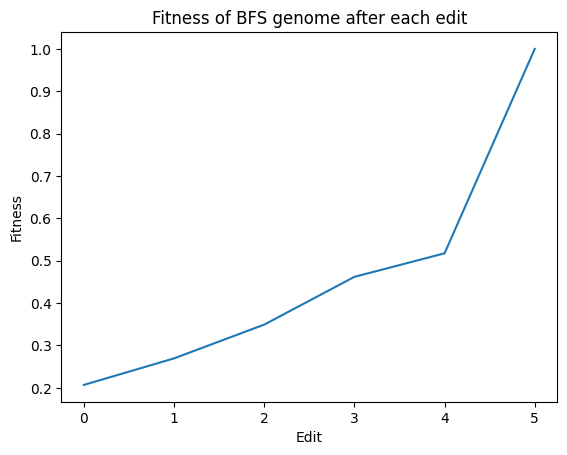

In [8]:
# plot the fitnesses

plt.plot(fitnesses)
plt.xlabel('Edit')
plt.ylabel('Fitness')
plt.title('Fitness of BFS genome after each edit')
plt.show()


In [9]:
# let's look at the edits in the genome
for g in bfs_genome.chromosomes:
    if g.edits:
        print(g)

Position: 14, Tag: 'struct', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 5, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 14 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 36, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 15, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 33 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 130, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 14, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 118 in prototype ffc9d4101c16b26beb74bedb363ecf0a63aab0145bbe379e43f950fdef0b44e0
Position: 228, Tag: 'function', Prototype 80d99b93cab0c85a2aa09aa965e4e04fffe551b191fb7d9a3ebe1be90159f204, Depth, 15, Weight: 1, Parents: [0], Edits:
	Edit: replace with position 161 in prototype ffc9d4101c16b26beb74bedb

## Genetic Improvement Process Demo

In [10]:

# define genetic process
import random
from sqlalchemy.sql.expression import func
from sqlalchemy import and_, or_
import math

import concurrent.futures
from copy import deepcopy

def eval(genome):
    """wrapper function to evaluate a genome on the evaluation server"""
    return genome.submit_to_evaluation(evaluation_server=settings['evaluation_server'])

mutation_rate = 0.01
crossover_rate = 0.0 # this is just a placeholder for now
population_size = 200
donor_pool = [dfs_hash]
editable_tags = ['struct', 'function', 'decl', 'condition']

# create a population of genomes
population = []

# record min, max, and mean fitnesses for each generation
mean_fitnesses = []
max_fitnesses = []
min_fitnesses = []

num_generations = 100

for gen in range(num_generations):

    # add fresh genomes to the population (randomly shuffle the chromosomes in the genome)
    for i in range(population_size):
        genome = Genome(prototype_hash=bfs_hash, build_genome=True, session=session)
        # shuffle the chromosomes
        random.shuffle(genome.chromosomes)
        population.append(genome)

    children = []
    # apply mutations to the population at the mutation rate specified
    # enforce rules to reduce the search space
    for genome in population:
        child = deepcopy(genome)
        for chromosome in child.chromosomes:
            if chromosome.tag in editable_tags:
                if random.random() < mutation_rate:
                    # normally we would select from the possible edits
                    # but for now, all edits are replace
                    edit_type = 'replace'
                    # select a random edit from ingredients
                    max_depth = chromosome.depth + 1
                    min_depth = chromosome.depth - 1
                    tag = chromosome.tag
                    ingredient = session.query(Ingredient).filter(
                        and_(
                            Ingredient.depth.between(min_depth, max_depth),
                            Ingredient.prototype.in_(donor_pool),
                            Ingredient.tag == tag
                            )
                        ).order_by(func.random()).first()
                    if ingredient:
                        edit = Edit(edit_type=edit_type, prototype_position=ingredient.position, prototype_hash=ingredient.prototype)
                        # chromosome.edits.append(edit)
                        chromosome.edits = [edit]
                    else:
                        # print(f"Could not find ingredient for {tag} at depth {chromosome.depth}")
                        pass
        children.append(child)                    

    # add children to the population
    population.extend(children)
    
    # remove genomes with no edits
    population = [g for g in population if any([c.edits for c in g.chromosomes])]

    # calculate fitness for the population
    # get the code for each genome
    for genome in population:
        genome.get_code(srcML_path=settings['srcml_client'], session=session)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [executor.submit(eval, genome) for genome in population]
    results = [r.result() for r in results]

    # get fitness for each genome
    for genome, result in zip(population, results):
        genome.calculate_fitness(result)

    # sort the population by fitness
    population = sorted(population, key=lambda g: g.fitness, reverse=True)
    
    # select to 50% of the population survive
    population = population[:population_size // 2]

    # find min, max, and mean fitness of the population
    fitnesses = [g.fitness for g in population]
    min_fitness = min(fitnesses)
    max_fitness = max(fitnesses)
    mean_fitness = sum(fitnesses) / len(fitnesses)
    mean_fitnesses.append(mean_fitness)
    max_fitnesses.append(max_fitness)
    min_fitnesses.append(min_fitness)

    print(f"Generation {gen}: Min: {min_fitness}, Max: {max_fitness}, Mean: {mean_fitness}")




Generation 0: Min: 0.18814329512127373, Max: 0.7222222222222222, Mean: 0.2852203195214245
Generation 1: Min: 0.27629797379916265, Max: 0.7222222222222222, Mean: 0.3395794560076858
Generation 2: Min: 0.32222222222222224, Max: 0.7777777777777778, Mean: 0.390619086346949
Generation 3: Min: 0.35407575157694043, Max: 0.7777777777777778, Mean: 0.4590408387219654
Generation 4: Min: 0.38926906350375456, Max: 0.7777777777777778, Mean: 0.5451560734794569
Generation 5: Min: 0.4577737819768366, Max: 0.7777777777777778, Mean: 0.6373449418336407
Generation 6: Min: 0.7222222222222222, Max: 0.7777777777777778, Mean: 0.731666666666667
Generation 7: Min: 0.7222222222222222, Max: 0.7777777777777778, Mean: 0.7372222222222227
Generation 8: Min: 0.7222222222222222, Max: 0.7777777777777778, Mean: 0.7522222222222232
Generation 9: Min: 0.7222222222222222, Max: 0.8333333333333334, Mean: 0.7744444444444448
Generation 10: Min: 0.7777777777777778, Max: 0.8333333333333334, Mean: 0.7805555555555549
Generation 11: Mi

KeyboardInterrupt: 

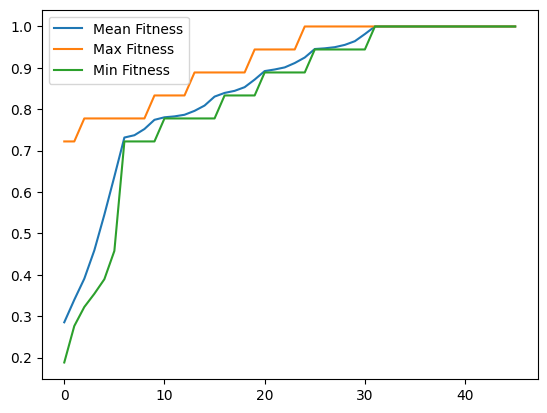

In [12]:
# graph fitnesses
import matplotlib.pyplot as plt

plt.plot(mean_fitnesses, label='Mean Fitness')
plt.plot(max_fitnesses, label='Max Fitness')
plt.plot(min_fitnesses, label='Min Fitness')
plt.legend()
plt.show()


In [33]:
i = 0
for genome in population:
    for chromosome in genome.chromosomes:
        for edit in chromosome.edits:
            if edit.prototype_position == 14:
                print(i, genome.fitness)
    i += 1

118 1.0
165 1.0
220 0
221 0
245 0
248 0


In [34]:
print(population[165].code)

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <windows.h>

// Queue structure for BFS
struct Stack {
    char** items;
    int top, size;
};

// Create a new empty queue
struct Stack* createQueue(int size) {
    struct Stack* queue = (struct Stack*)malloc(sizeof(struct Stack));
    queue->items = (char**)malloc(size * sizeof(char*));
    queue->front = -1;
    queue->rear = -1;
    queue->size = size;
    return queue;
}

// Enqueue an item into the queue
void enqueue(struct Stack* queue, const char* item) {
    if (queue->rear == queue->size - 1) {
        printf("Queue is full");
    } else {
        if (queue->front == -1) {
            queue->front = 0;
        }
        queue->rear++;
        queue->items[queue->rear] = strdup(item);
    }
}

// Dequeue an item from the queue
char* dequeue(struct Stack* queue) {
    if (queue->front == -1 || queue->front > queue->rear) {
        printf("Queue is empty");
        return NULL;
    } else {
        char* item = 